In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import skimage
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

%matplotlib inline

In [3]:
_ = np.seterr(divide='ignore', invalid='ignore')

In [4]:
image = np.asarray(Image.open("data/pinocio.png"))

In [5]:
image.shape

(752, 860, 3)

In [6]:
def show_image(image):
    plt.figure(figsize=(6,6))
    plt.imshow(image, cmap='gray')
    plt.show()

Исходное изображение

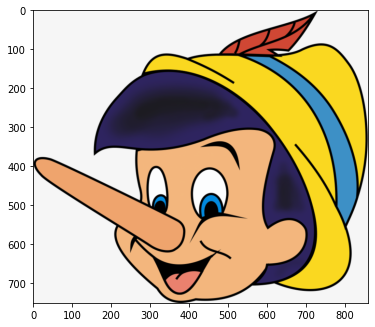

In [7]:
show_image(image)

In [8]:
poluton = np.uint8(image.mean(2))

Полутоновое изображение

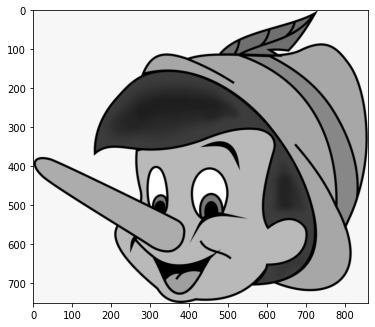

In [9]:
show_image(poluton)

Оператор Шарра 3x3

$
G_x = \begin{bmatrix}
3 & 0 & -3\\
10 & 0 & -10\\
3 & 0 & -3
\end{bmatrix}
\ast A
$

$
G_y = \begin{bmatrix}
3 & 10 & 3\\
0 & 0 & 0\\
-3 & -10 & -3
\end{bmatrix}
\ast A
$

$
\nabla f \approx |G_x| + |G_y|
$

In [10]:
def calc_gradient(poluton, operator):
    patches = skimage.util.view_as_windows(poluton, operator.shape)  # (H', W', OH, OW)
    result = (patches * operator).sum((2, 3))
    return result

def normalize_gradient(gradient):
    result = np.uint8(gradient / gradient.max() * 255)
    return result

In [11]:
def otsu_threshold(image):
    image = image.flatten()
    hist = np.bincount(image, minlength=256)  # (256,)
    nonzero = hist.nonzero()[0]  # (N,)
    hist = hist[nonzero] / len(image)  # (N,)
    
    w_0 = hist.cumsum()  # (N,)
    w_1 = 1 - w_0  # (N,)
    
    cumsum = (nonzero * hist).cumsum()  # (N,)
    M_0 = cumsum / w_0  # (N,)
    M_1 = (cumsum[-1] - cumsum) / w_1  # (N,)
    
    grid = nonzero[None].repeat(len(nonzero), axis=0)  # (N, N)
        
    D_0 = grid - M_0[:, None]  # (N, N)
    D_0 = D_0**2 * hist  # (N, N)
    D_0 = np.tril(D_0).sum(1)  # (N,)
    
    D_1 = grid - M_1[:, None]  # (N, M)
    D_1 = D_1**2 * hist  # (N, N)
    D_1 = np.triu(D_1, k=1).sum(1)  # (N,)
    
    D_intra = w_0 * D_0 + w_1 * D_1  # (N,)
    D_inter = w_0 * w_1 * (M_0 - M_1)**2  # (N,)
    
    argmax = np.nanargmax(D_inter / D_intra)
    threshold = nonzero[argmax]
    M_0 = int(M_0[argmax].item())
    M_1 = int(M_1[argmax].item())
    
    return threshold, M_0, M_1


def binarize_by_threshold(poluton, threshold, out=None):
    if out is None:
        out = np.zeros(poluton.shape, dtype=bool)
    out[poluton >= threshold] = True
    return out


def otsu_binarize(poluton):
    threshold = otsu_threshold(poluton)[0]
    result = binarize_by_threshold(poluton, threshold)
    return result

In [12]:
sharp_x = np.array([
    [3, 0, -3],
    [10, 0, -10],
    [3, 0, -3],
], dtype=np.int32)

sharp_y = np.array([
    [3, 10, 3],
    [0, 0, 0],
    [-3, -10, -3],
], dtype=np.int32)

In [13]:
G_x = calc_gradient(poluton, sharp_x)
G_y = calc_gradient(poluton, sharp_y)
G = np.abs(G_x) + np.abs(G_y)

In [14]:
G_x_norm = normalize_gradient(G_x)
G_y_norm = normalize_gradient(G_y)
G_norm = normalize_gradient(G)

Нормализованная градиентная матрица $G_x$

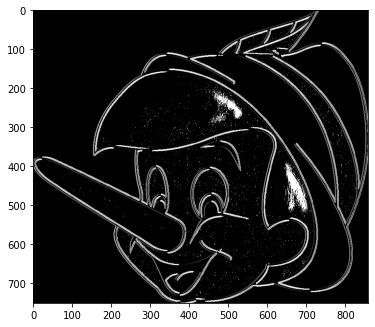

In [15]:
show_image(G_x_norm)

Нормализованная градиентная матрица $G_y$

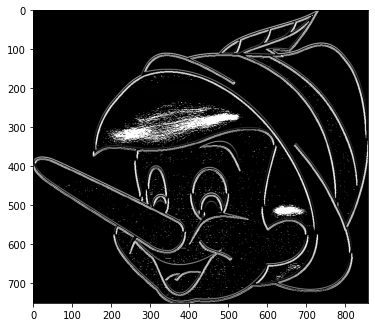

In [16]:
show_image(G_y_norm)

Нормализованная градиентная матрица $\nabla f$

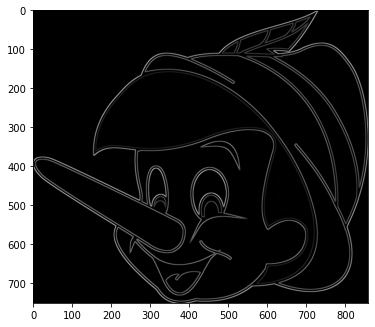

In [17]:
show_image(G_norm)

In [18]:
G_binary = otsu_binarize(G_norm)

Бинаризованная градиентная матрица $\nabla f$

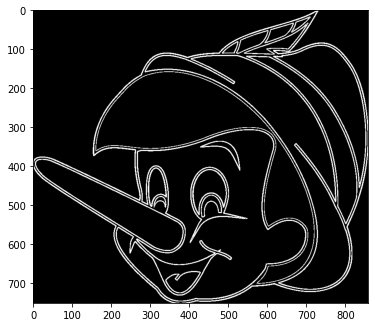

In [19]:
show_image(G_binary)